In [75]:
import sys
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/climax')
sys.path.append('/mnt/shared/users/wessim.omezzine/ClimaX/src/')
import torch 
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime
from torchvision.transforms import transforms
import torch.nn.functional as F
from prettytable import PrettyTable
from scipy import stats
import cv2

from skimage.metrics import structural_similarity as ssim


from climax.climate_downscaling.module import ClimateDownscalingModule
from climax.climate_downscaling.datamodule import ClimateDownscalingDataModule
from pytorch_lightning.cli import LightningCLI
from pytorch_lightning import Trainer
from climax.arch import ClimaX



In [2]:
task = "10 days"
pred_range = TASK_TO_RANGE[task]

net_args = {
    'default_vars': [
        'forecast', 'rfh_lta', 'rfh','r2h','r3h']
    ,"img_size" :  [32, 32],
      "patch_size" :  2,
      "embed_dim":   2048,
      "depth" : 8,
      "decoder_depth" :  2,
      "num_heads": 16,
    "mlp_ratio": 2,
    "drop_path": 0.5,
    "drop_rate": 0.5,
    
}
net = ClimaX(**net_args)
model = ClimateDownscalingModule(net=net, pretrained_path='ClimaX/exps/downscale/checkpoints/epoch_000-v4.ckpt')

datamodule = ClimateDownscalingDataModule(root_dir=f'Data/Downscaling/Rainfall/Indonesia/data_npz',
    variables=['forecast', 'rfh_lta', 'r2h','r3h'],
    out_variables=['rfh'],
    buffer_size= 2000,
    batch_size= 45
)

normalization = datamodule.transforms
print(normalization)
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())


datamodule.setup()

Loading pre-trained checkpoint from: ClimaX/exps/downscale/checkpoints/epoch_000-v4.ckpt
<All keys matched successfully>
Normalize(mean=[252.4624176  308.69473376 640.04875945 987.11611821], std=[ 48.96100235  47.42474261  81.11266039 112.01201785])


In [43]:
dataloader = datamodule.test_dataloader()
desired_batch_index=1
for batch_idx, batch_data in enumerate(dataloader, 1):        
        if batch_idx == desired_batch_index:
            # Process the nth batch (e.g., 10th batch)
            x, y, lead_times, in_vars, out_vars = batch_data
            
inv_normalize = model.denormalization

In [56]:
import numpy as np

# Assuming datamodule.transforms.std and datamodule.transforms.mean are NumPy arrays
# of shape (4,) and (4,) respectively

# Expand the dimensions of the standard deviation and mean NumPy arrays to match the shape of x
broadcasted_std = datamodule.transforms.std.reshape(1, 4, 1, 1)
broadcasted_std = np.tile(broadcasted_std, (45, 1, 32, 32))

broadcasted_mean = datamodule.transforms.mean.reshape(1, 4, 1, 1)
broadcasted_mean = np.tile(broadcasted_mean, (45, 1, 32, 32))

# Now, you can denormalize x by multiplying and adding as follows
denormalized_x = (x * broadcasted_std) + broadcasted_mean


In [202]:
import numpy as np
# Define a custom weighting function (e.g., higher weights in center)
def custom_weight_function_mean(square):
    normalized_weights = square/np.mean(square)
    return normalized_weights

def custom_weight_function(square):
    local_std = np.std(square)
    normalized_weights = local_std / np.mean(square)
    
    
    return normalized_weights

def Downscale_Weight(rfh_lta,forecast, verbose=False):

    # Initialize an empty weight mask
    weight_mask = np.zeros_like(forecast)

    # Compute weights and apply them
    
    step = 10
    for row in range(0,30,step):
        for col in range(0,60,10):
            rfh_lta_square = rfh_lta[row:row + step, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, col:col + step] = weights
            
    
    for row in range(0,32,step):
            rfh_lta_square = rfh_lta[row:row + step, 60:]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[row:row + step, 60:] = weights
        
        
    for col in range(0,64,step):
            rfh_lta_square = rfh_lta[30:, col:col + step]
            weights = custom_weight_function_mean(rfh_lta_square)
            weight_mask[30:, col:col + step] = weights



    # Apply the weight mask to forecast
    weighted_forecast = forecast * weight_mask


    if verbose:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        axes[0].imshow(forecast)
        axes[1].imshow(rfh_lta)
        axes[2].imshow(weighted_forecast)
        axes[3].imshow(weighted_forecast-rfh_lta)

        axes[0].set_title(f"forecastKm", fontsize='xx-large')
        axes[1].set_title(f"rfh_lta", fontsize='xx-large')
        axes[2].set_title(f"NDVI_Downscaled_det", fontsize='xx-large')
        axes[3].set_title(f"Bias", fontsize='xx-large')
        plt.show()

    return weighted_forecast

/mnt/shared/users/wessim.omezzine/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/shared/users/wessim.omezzine/.local/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


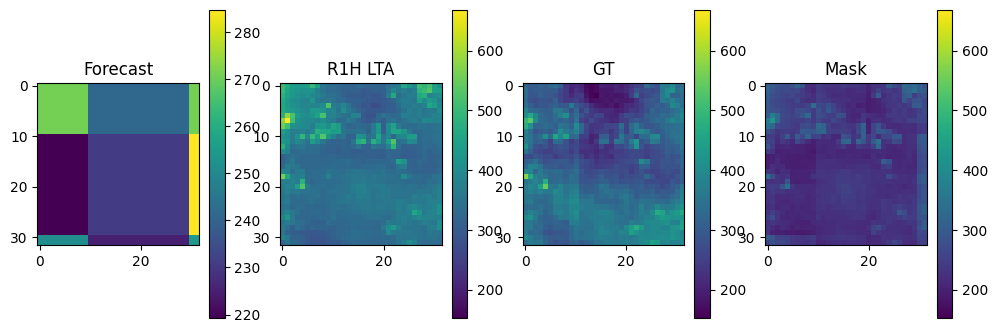

In [203]:
time = 1
forecast = denormalized_x[time, 0].cpu().numpy()
r1h_lta = denormalized_x[time, 1].cpu().numpy()
gt = (y * datamodule.output_transforms.std + datamodule.output_transforms.mean)[time, 0]
weighted = Downscale_Weight(r1h_lta,forecast,False)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))

im1 = ax1.imshow(forecast)
ax1.set_title('Forecast')
cbar1 = fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(r1h_lta)
ax2.set_title('R1H LTA')
cbar2 = fig.colorbar(im2, ax=ax2)

im3 = ax3.imshow(gt)
ax3.set_title('GT')
cbar3 = fig.colorbar(im3, ax=ax3)

im4 = ax4.imshow(weighted)
ax4.set_title('Mask')
cbar4 = fig.colorbar(im4, ax=ax4)

# Ensure the colorbars have the same scale
vmin = min(cbar2.vmin, cbar3.vmin, cbar4.vmin)
vmax = max(cbar2.vmax, cbar3.vmax, cbar4.vmax)
im2.set_clim(vmin, vmax)
im3.set_clim(vmin, vmax)
im4.set_clim(vmin, vmax)

# Display the figure
plt.show()


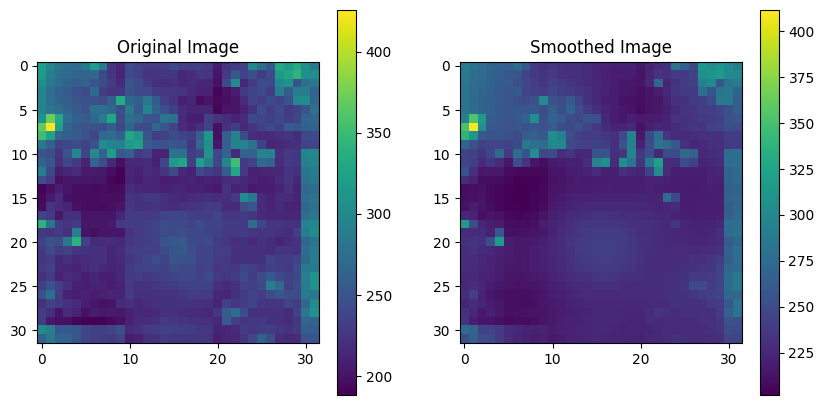

In [217]:
# Define the parameters for the bilateral filter

# Convert the image to 8-bit format
weighted = weighted.astype(np.float32)

d = 9  # Diameter of each pixel neighborhood
sigma_color = 30 # Filter sigma in the color space
sigma_space = 100  # Filter sigma in the coordinate space


# Apply the bilateral filter
smoothed_image = cv2.bilateralFilter(weighted, d, sigma_color, sigma_space)

# Display the original and smoothed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(weighted)
plt.title('Original Image')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(smoothed_image)
plt.title('Smoothed Image')
plt.colorbar()


plt.show()